<font size = 6 color = 'blue'>
<center> Notebook 2: Clasificador Transfer Learning </center>

<font size = 5 color = 'blue'>
<center> Implementación de una Red Neuronal Artificial Convolucional utilizando la técnica de Transfer Learning y Fine Tuning </center>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<font size = 6 color = 'royalblue'>
1.- Bibliotecas y configuración de la sesión

<font size = 4 color='black'>
Para la implementación del modelo no es indispensable pero sí sumamente sugerido realizar el entrenamiento del mismo en una unidad de procesamiento GPU. Google Colab provee acceso gratuito a estas unidades.

<font size = 4 color='black'>

Google Colab tiene previemente configuradas sus unidades de procesamiento.
Si se contara con una unidad GPU en su computadora personal, <i>__Nvidia__</i> ofrece una [guía](https://developer.nvidia.com/cuda-toolkit-archive) detallada para la configuración de la unidad a través de CUDA.

<font size = 4 color='black'>

Por su parte, <i>__Tensorflow__</i> a partir de su versión <i>__2.X__</i> implementa de manera automática la ejecución de procesos de Deep Learning a través de su biblioteca <i>__Tensorflow-GPU__</i>. Se puede encontrar más información [aquí](https://www.tensorflow.org/install/gpu?hl=es-419).

In [2]:
import time
import itertools
import numpy as np
import random as rn
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as PRFS

from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

rn.seed(1)
np.random.seed(1)


<font size = 4 color='black'>

Si el GPU lo permite, es posible habilitar la <i>__precisión mixta__</i> en los flotantes.

In [3]:
keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


Más información sobre la precisión mixta en el siguiente [link](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/set_global_policy)


Podemos verificar el tipo de GPU con el que estamos trabajando con la siguiente instrucción:

In [4]:
!nvidia-smi

Thu Aug 26 18:31:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<font size = 6 color = 'royalblue'>
2.- Procesamiento de los datos

<font size=5 color='black'>
Levantamos los dataframes generados en el Notebook 0.

In [5]:
df = pd.read_pickle('/content/drive/MyDrive/Clasificador_from_scratch/images_for_training.pkl')

print("El dataframe con los datos para entrenar tiene {} arreglos correspondientes a las imágenes en la base aumentada."\
      .format(len(df)))

El dataframe con los datos para entrenar tiene 1815 arreglos correspondientes a las imágenes en la base aumentada.


<font size=4 color='black'>
La generación de los dataframes en el preprocesamiento organiza y simplifica considerablemente el tratamiento previo a entrenar.

<font size=4 color='black'>

El número que aparece en <i>__categoría__<i> en el Dataframe corresponde al tipo de mineral de acuerdo al siguiente diccionario.

In [6]:
dic = {0 : "muscovite",
       1 : "malachite",
       2 : "biotite",
       3 : "chrysocolla",
       4 : "pyrite",
       5 : "quartz",
       6 : "bornite"}

<font size = 5 color = 'royalblue'>
2.2.- Procesamiento

<font size=4 color='black'>

Existen imágenes que tienen 4 canales en lugar de los 3 canales usuales <i>__RGB__</i>. Es necesario que todas las imágenes tengan el mismo formato para que no existan problemas al incorporarlas en <i>__Keras__</i>, por esta razón se eliminan aquellas imágenes que tengan dimensiones diferentes a <i>__(224, 224, 3)__</i>.

<font size=4 color='black'>

Primero encontramos las imágenes con formato diferente.

<font size=4 color='black'>

Convertimos la columna <i>__images__</i> en un arreglo de numpy para facilitar su manejo

In [7]:
imagenes = np.array( df["images"][:] )

<font size=4 color='black'>

Generamos un filtro que nos permite ubircar las imágenes con dimensiones diferentes a los deseados.

In [8]:
images_accurate = []
images_with_issues = []
index = []

for i in range(len(imagenes)):
    if imagenes[i].shape != (224,224,3):
        
            image = imagenes[i]   
            images_with_issues.append(image)
            index.append(i)
    
        
    image = imagenes[i]   
    images_accurate.append(image)
    
print("Los índices de las imágenes con errores son: {}. En total {} imágenes a eliminar."\
      .format(index, len(images_with_issues)))

Los índices de las imágenes con errores son: [388, 464, 593, 935, 939, 1132, 1378, 1682, 1703]. En total 9 imágenes a eliminar.


<font size=4 color='black'>

Una vez que se ubicó el índice que tienen estas imágenes en el DataFrame, eliminamos las imágenes con el método de <i>__Pandas__</i>: <i>DataFrame.drop()</i>

In [9]:
for i in range(len(index)):
    df = df.drop(index[i])
    
print("El nuevo tamaño del Dataframe es {}".format(len(df)))

El nuevo tamaño del Dataframe es 1806


Sobre el método [DataFrame.drop()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html).

<font size = 4 color='black'>

Almacenamos los arreglos de las imágenes en una lista, la cual será un argumento tomará el método <i>__Model.fit()__</i> de keras para el entrenamiento. 

In [10]:
images = np.array(df["images"][:])

X = []

for i in range(len(images)):
    
    image = images[i]   
    
    X.append(image)
    
print("El tamaño de la lista X la cual contiene las variables de entrada es {}".format(len(X)))

El tamaño de la lista X la cual contiene las variables de entrada es 1806


<font size = 5 color = 'royalblue'>
2.3.- Normalización

<font size = 4 color='black'>

Ya que el rango de valores para cada filtro <i>__RGB__</i> va de <i>__0__</i> a <i>__255__</i>, dividimos por 255 al valor de cada entrada en cada uno de los arreglos en la lista <i>__X__</i>. Esto estandariza los datos con valores entre 0 y 1.
    
Observemos los valores del primer arreglo antes de normalizar:

In [11]:
X[5][0][0]

array([183, 195, 211], dtype=uint8)

<font size = 4 color='black'>
Aplicamos la normalización

In [12]:
X_norm = np.array(X) / 255

<font size = 4 color='black'>

Observamos los valores del primer arreglo después de normalizar.

In [13]:
X_norm[5][0][0]

array([0.7176471, 0.7647059, 0.827451 ], dtype=float32)

<font size = 5 color = 'royalblue'>
2.4.- Generación de las etiquetas de los datos para alimentar a la red neuronal

<font size = 4 color='black'>

Las etiquetas de los arreglos de imágenes con los que se alimentará a la red neuronal corresponden a la clase de mineral a la que pertenece cada uno de estos arreglos.
Recordemos que cada uno de estos <i>__arreglos__</i> (correspondiente a una imagen de la base de datos) tiene asignada una <i>__etiqueta__</i>, en este caso, designada con un número del <i>__0__</i> al <i>__6__</i> ya que tenemos <i>__7__</i> clases de minerales.

<font size = 4 color='black'>

Obtenemos las etiquetas directamente del Dataframe y las ordenamos de manera que coincidan con las variables de entrada X.

In [14]:
y = np.array(df["category"][:])
print("La dimensión de y era {}".format(y.shape))

y = y.reshape((y.shape[0],1))
print("La dimensión de y ahora es {}".format(y.shape))

La dimensión de y era (1806,)
La dimensión de y ahora es (1806, 1)


<font size = 4 color='black'>

Una buena práctica para hacer más eficiente el cálculo en el entrenamiento es cambiar el formato de las etiquetas a un vector a través de un método denominado <i>__one-hot encoding__</i>. Para esto utilizamos el método de Keras <i>__to_categorical__</i>.
    
Originalmente las etiquetas son de la forma:

In [15]:
y[300][0]

1

<font size = 4 color='black'>

Aplicamos One-hot encoding:

In [16]:
y_one_hot = to_categorical(y)

<font size = 4 color='black'>

Ahora las etiquetas son de la forma:

In [17]:
y_one_hot[300]

array([0., 1., 0., 0., 0., 0., 0.], dtype=float32)

Sobre el método [to_categorical()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)

<font size = 4 color='black'>

La dimensión final de la lista con las etiquetas es:

In [18]:
y_one_hot.shape

(1806, 7)

<font size = 5 color = 'royalblue'>
2.5.- Reordenamiento aleatorio

<font size = 4 color='black'>

A manera de eliminar cualquier sesgo proviniente del orden original de los datos de entrada (en este caso de las imágenes en la base aumentada) se reordenan de manera aleatoria las parejas de arreglos y etiquetas utilizando el método de Numpy <i>__random.permutation()__</i>.

In [19]:
idx = np.random.permutation(len(X_norm))

X_norm_permut, y_one_hot_permut = X_norm[idx], y_one_hot[idx]

Sobre el método [random.permutation()](https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html)

<font size = 6 color = 'royalblue'>
3.- Separación de los datos para alimentar a la red neuronal en los conjuntos para entrenamiento, validación y prueba

<font size = 4 color='black'>

Para este trabajo se seleccionó un <i>__80%__</i> de los datos totales para entrenar a la red neuronal. Un <i>__10%__</i> para el conjunto de validación y un <i>__10%__</i> para el conjunto de prueba.

<font size = 4 color='black'>

Defininos el número de imágenes en los conjuntos de validación y prueba.

In [20]:
# Calculamos el número de arreglos o imágenes correspondientes al conjunto de validación
val_split_num = int(round( 0.10 * len(y) ))
print("Hay un total de {} imágenes para validar".format(val_split_num))

# Calculamos el número de arreglos o imágenes correspondientes al conjunto de prueba
test_split_num = int(round( 0.10 * len(y) ))
print("\nHay un total de {} imágenes para el conjunto de prueba".format(test_split_num))

Hay un total de 181 imágenes para validar

Hay un total de 181 imágenes para el conjunto de prueba


<font size = 4 color='black'>

Efectuamos la separación.

In [21]:
train_x = X_norm_permut[test_split_num + val_split_num:]
train_y = y_one_hot_permut[test_split_num + val_split_num:]

val_x = X_norm_permut[test_split_num: test_split_num + val_split_num]
val_y = y_one_hot_permut[test_split_num: test_split_num + val_split_num]

test_x = X_norm_permut[:test_split_num]
test_y = y_one_hot_permut[:test_split_num]

<font size = 4 color ='black'>

Comprobamos las dimensiones de los conjuntos de entrenamiento, validación y prueba:

In [22]:
print ("train_x shape: " + str(train_x.shape))
print ("train_y shape: " + str(train_y.shape))

print ("val_x shape: " + str(val_x.shape))
print ("val_y shape: " + str(val_y.shape))

print ("test_x shape: " + str(test_x.shape))
print ("test_y shape: " + str(test_y.shape))

train_x shape: (1444, 224, 224, 3)
train_y shape: (1444, 7)
val_x shape: (181, 224, 224, 3)
val_y shape: (181, 7)
test_x shape: (181, 224, 224, 3)
test_y shape: (181, 7)


In [23]:
train_x[0].shape

(224, 224, 3)

<font size = 6 color = 'royalblue'>
4.- Implementación de la red neuronal

<font size = 5 color = 'royalblue'>
4.1.- Bloque Convolucional

<font size = 4 color='black'>

Definimos la base convolucional. 
En este caso, por la naturaleza del problema y por a su bajo número de parámetros, elegimos la arquitectura MobilNet cuyo artículo donde fue diseñada puede consultarse [aquí](https://arxiv.org/abs/1704.04861).

In [24]:
conv_base = tf.keras.applications.mobilenet.MobileNet(input_shape=(224,224,3), alpha=1.0, 
                                                      depth_multiplier=1, 
                                                      dropout=0.001,
                                                      include_top=False,
                                                      pooling="max",
                                                      weights='imagenet'
                                                      )

#Definir los bloques como no entrenables
conv_base.trainable = False  ### Para hacer efectivo el método de Fine Tuning es importante definir en su totalidad la 
                              ## la base convolucional con sus pesos congelados ("freeze")

17235968/17225924 [==============================] - 0s 0us/step


<font size = 4 color='black'>

Documentación [MobileNet](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/MobileNet).

<font size = 4 color='black'>

Resumen de la arquitectura de la red neuronal:

In [25]:
conv_base.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

<font size = 4 color='black'>

Puedes comparar el tamaño, de acuerdo a sus parámetros, de diferentes modelos de Deep Learning [aquí](https://keras.io/api/applications/).

<font size = 5 color = 'royalblue'>
4.2.- Data Augmentation

<font size = 4 color='black'>

Un método alternativo a los generadores es utilizar las capas <i>__experimental.preprocessing__</i>. Su documentación [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing).

In [26]:
#Definimos las transformaciones a las imágenes en la Data Augmentation

data_augmentation = keras.Sequential(
[
tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
tf.keras.layers.experimental.preprocessing.RandomRotation(0.1), #fracción 0.1 de 2Pi
tf.keras.layers.experimental.preprocessing.RandomZoom(0.2), #Fracción positiva zoom que acerca la imagen
]
)

<font size = 5 color = 'royalblue'>
4.3.- Arquitectura completa incluyendo Top Model

<font size = 4 color='black'>

Definimos la arquitectura completa del modelo.
Nótese que únicamente estamos definiendo un modelo <i>__fully connected__</i> en el top de la base convolucional.

In [36]:
#Arquitectura del modelo

#Entrada de arreglos (imágenes) con shape = (224,224,3)
inputs = tf.keras.Input(shape=(224,224,3))

#Dos capas de Data Augmentation
x = data_augmentation(inputs)
x = data_augmentation(x)

#Base Convolucional
x = conv_base(x)

#Capa flatten previo al modelo fully connected
x = tf.keras.layers.Flatten()(x)

#Capa fully connected
x = Dense(256, activation='relu')(x)

#Capa de Batch normalization
x = BatchNormalization()(x)

#Capa de Dropout
x = Dropout(0.5)(x)

#Capa de salida con función Softmax (asigna una "probabilidad" a cada imágen de salida)
outputs = Dense(7, activation="softmax")(x)

#Definición del modelo
model = tf.keras.Model(inputs, outputs)

#Compilar el modelo
model.compile(optimizer = "adam" , loss =  "categorical_crossentropy", metrics = "accuracy")

Sobre el método [optimizers.Adam()](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

Sobre el método [losses.CategoricalCrossentropy()](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy)

Sobre el método [metrics.Accuracy()](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy)

Sobre las [métricas](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) disponibles en Tensorflow Keras.

In [37]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 3)  0           input_4[0][0]                    
                                                                 sequential[4][0]                 
__________________________________________________________________________________________________
mobilenet_1.00_224 (Functional) (None, 1024)         3228864     sequential[5][0]                 
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 1024)         0           mobilenet_1.00_224[2][0]   

<font size = 4 color='black'>

Definición de <i>__callbacks__</i>.

In [39]:
#Definimos únicamente un checkpoint para guardar y que sobrescriba el modelo cada vez que la métrica en cuestión mejora

callbacks = [
             keras.callbacks.ModelCheckpoint(
                 filepath = "/content/drive/MyDrive/Clasificador_from_scratch/Mejor_modelo_TL/Pre_FT.h5",
                 save_best_only = True,
                 monitor="val_loss"),
             keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=10)
            ]

<font size = 5 color = 'royalblue'>
4.4.- Entrenamiento

In [40]:
#Entrenamiento

history = model.fit(train_x,  train_y,
                    batch_size = 128,
                    epochs=50,
                    validation_data = (val_x, val_y),
                    callbacks = callbacks)

Epoch 1/50
12/12 [==============================] - 4s 158ms/step - loss: 1.8555 - accuracy: 0.4065 - val_loss: 2.2596 - val_accuracy: 0.5856
Epoch 2/50
12/12 [==============================] - 1s 108ms/step - loss: 0.9344 - accuracy: 0.6898 - val_loss: 1.2338 - val_accuracy: 0.7238
Epoch 3/50
12/12 [==============================] - 1s 105ms/step - loss: 0.6956 - accuracy: 0.7625 - val_loss: 1.1652 - val_accuracy: 0.7017
Epoch 4/50
12/12 [==============================] - 1s 104ms/step - loss: 0.6177 - accuracy: 0.7888 - val_loss: 0.5413 - val_accuracy: 0.8287
Epoch 5/50
12/12 [==============================] - 1s 106ms/step - loss: 0.5263 - accuracy: 0.8144 - val_loss: 0.5331 - val_accuracy: 0.8729
Epoch 6/50
12/12 [==============================] - 1s 103ms/step - loss: 0.5138 - accuracy: 0.8331 - val_loss: 0.4027 - val_accuracy: 0.8508
Epoch 7/50
12/12 [==============================] - 1s 103ms/step - loss: 0.4753 - accuracy: 0.8463 - val_loss: 0.4554 - val_accuracy: 0.8564
Epoch 

Sobre el método [Model.fit()](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)

<font size = 4 color='black'>

Podemos guardar el modelo ya entrenado:

In [41]:
#Guardar el modelo (opcional)
model.save('/content/drive/MyDrive/Clasificador_from_scratch/Mejor_modelo_TL/pre_FT.h5')


<font size = 5 color = 'royalblue'>
4.5.- Gráficas de costo y accuracy

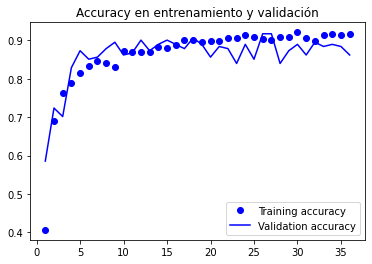

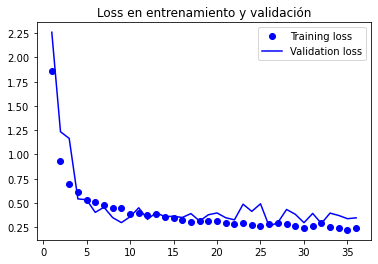

In [42]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

#print(len(acc), len(val_acc), len(loss), len(val_loss))
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Accuracy en entrenamiento y validación")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Loss en entrenamiento y validación")
plt.legend()
plt.show()

<font size = 6 color = 'royalblue'>
5.- Fine Tuning

<font size = 4 color='black'>

Recordemos brevemente la arquitectura del bloque convolucional.

In [43]:
conv_base.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

<font size = 4 color='black'>

La idea es <i>__descongelar únicamente los bloques convolucionales superiores__</i> del bloque convolucional.

<font size = 4 color='black'>

En este caso descongelaremos únicamente última capa convolucional y la que tiene más parámetros de todas.

In [44]:
#Descongelamos todas las capas de la red neuronal
conv_base.trainable = True

In [45]:
#Congelamos todas las capas previas a la deseada
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [46]:
#Decongelamos todas las capas posteriores a la de interés
for layer in conv_base.layers[-3:]:
    layer.trainable = False

<font size = 4 color='black'>

Observamos los resultados de este descongelamiento

In [47]:
conv_base.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

<font size = 4 color='black'>

Volvemos a entrenar pero esta vez utilizando un learning rate muy bajo.
Esto en el sentido de no alterar demasiado los pesos ya generados.

In [48]:
#Compilamos nuevamente el modelo PERO con un valor muy bajo en el learning rate
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001) , loss = "categorical_crossentropy", metrics = "accuracy")

#Definimos un nuevo callback cambiando la ruta de la carpeta donde se almacenan los checkpoints
callbacks = [
             keras.callbacks.ModelCheckpoint(
                 filepath = "/content/drive/MyDrive/Clasificador_from_scratch/Mejor_modelo_TL/After_FT.h5",
                 save_best_only=True,
                 monitor="val_loss")    
            ]
#Entrenamiento
history = model.fit(train_x, train_y,
                    batch_size = 128,
                    epochs=50,
                    validation_data = (val_x, val_y),
                    callbacks = callbacks)

Epoch 1/50
12/12 [==============================] - 5s 153ms/step - loss: 0.2300 - accuracy: 0.9224 - val_loss: 0.3455 - val_accuracy: 0.8564
Epoch 2/50
12/12 [==============================] - 1s 108ms/step - loss: 0.2370 - accuracy: 0.9107 - val_loss: 0.3356 - val_accuracy: 0.8619
Epoch 3/50
12/12 [==============================] - 1s 106ms/step - loss: 0.2118 - accuracy: 0.9335 - val_loss: 0.3238 - val_accuracy: 0.8785
Epoch 4/50
12/12 [==============================] - 1s 104ms/step - loss: 0.2275 - accuracy: 0.9259 - val_loss: 0.3172 - val_accuracy: 0.9006
Epoch 5/50
12/12 [==============================] - 1s 106ms/step - loss: 0.2301 - accuracy: 0.9238 - val_loss: 0.3135 - val_accuracy: 0.9006
Epoch 6/50
12/12 [==============================] - 1s 106ms/step - loss: 0.2322 - accuracy: 0.9252 - val_loss: 0.3065 - val_accuracy: 0.9061
Epoch 7/50
12/12 [==============================] - 1s 107ms/step - loss: 0.2463 - accuracy: 0.9190 - val_loss: 0.3086 - val_accuracy: 0.8950
Epoch 

<font size = 5 color = 'royalblue'>
5.1.- Gráficas de costo y accuracy

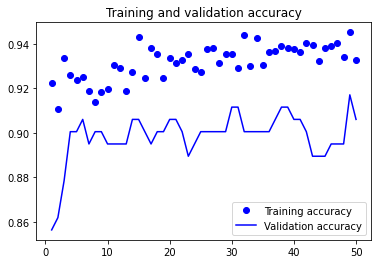

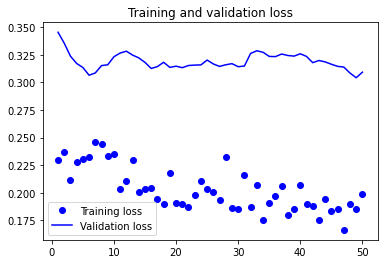

In [49]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

#print(len(acc), len(val_acc), len(loss), len(val_loss))
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

<font size = 4 color='black'>
Evaluación en el conjunto de test

<font size = 5 color = 'red'>
Ya que el entrenamiento pudiera demorar mucho tiempo, un modelo previamente entrenado pero con la misma arquitectura e hiperparámetros es incluido en la carpeta de trabajo, este se llama <i>trained_model_mineral_classifier.h5<i>.

<font size = 5 color = 'black'>
Cargamos el modelo pre entrenado con el método de Keras: <i>tf.keras.models.load_model()<i>.

In [50]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Clasificador_from_scratch/Mejor_modelo_TL/After_FT.h5')

<font size = 4 color='black'>
Evaluamos

In [53]:
test_loss, test_acc = model.evaluate(test_x, test_y)
print(f"Test accuracy: {test_acc:.3f}")

6/6 [==============================] - 1s 34ms/step - loss: 0.3913 - accuracy: 0.8840
Test accuracy: 0.884


<font size = 6 color = 'royalblue'>
5.- Métricas

In [54]:
dic = {0 : "muscovite",
       1 : "malachite",
       2 : "biotite",
       3 : "chrysocolla",
       4 : "pyrite",
       5 : "quartz",
       6 : "bornite"}

<font size = 5 color = 'royalblue'>
5.1.- Cálculo de las métricas en el conjunto de prueba

In [56]:
out_pred_test = model.predict(test_x)

prediction_test = out_pred_test >= 0.5
        
precision_test, recall_test, fscore_test, support_test = PRFS(test_y, prediction_test)

precision_test = np.round(100*precision_test, 2)
recall_test = np.round(100*recall_test, 2)
fscore_test = np.round(100*fscore_test, 2)

cnf_matrix_test = confusion_matrix(test_y.argmax(axis = 1), prediction_test.argmax(axis = 1))

print("\nprecision_train: {} \n\nrecall_train: {} \n\nfscore_train: {} \n\nTotal de muestras: {}"\
      .format(precision_test, recall_test, fscore_test, support_test))


precision_train: [ 94.44 100.    95.65  74.07  95.24  86.11  85.71] 

recall_train: [ 85.    73.53  95.65  86.96  83.33 100.    92.31] 

fscore_train: [89.47 84.75 95.65 80.   88.89 92.54 88.89] 

Total de muestras: [20 34 23 23 24 31 26]


In [59]:
dic = {0 : "muscovite",
       1 : "malachite",
       2 : "biotite",
       3 : "chrysocolla",
       4 : "pyrite",
       5 : "quartz",
       6 : "bornite"}

list_clases = [dic[classe] for classe in dic]

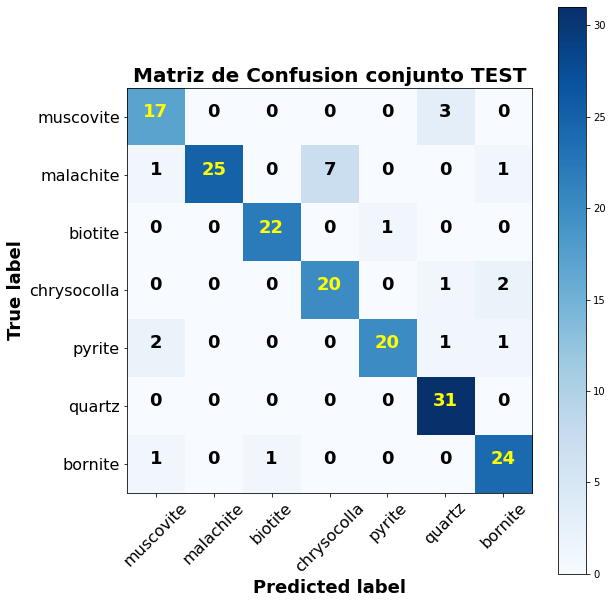

In [60]:
cm = cnf_matrix_test
classes = list_clases
cmap = plt.cm.Blues
title = 'Matriz de Confusion conjunto TEST'
normalize = False


plt.rcParams['figure.figsize']=(9,9)
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title, fontsize=20, fontweight='bold')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, fontsize=16)
plt.yticks(tick_marks, classes, fontsize=16)

fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
    horizontalalignment="center",
    color="yellow" if cm[i, j] > thresh else "black",
    fontsize=18, fontweight='bold')

plt.ylabel('True label', fontsize=18, fontweight='bold')
plt.xlabel('Predicted label', fontsize=18, fontweight='bold')
plt.tight_layout()

# Inferencias

In [61]:
df_inferences = pd.read_pickle('/content/drive/MyDrive/Clasificador_from_scratch/images_for_inferences.pkl')

print("\nEl dataframe con los arreglos correspondientes a las imágenes para hacer inferencia tiene {} arreglos."\
      .format(len(df_inferences)))


El dataframe con los arreglos correspondientes a las imágenes para hacer inferencia tiene 33 arreglos.


In [62]:
imagenes_inf = np.array( df_inferences["images"][:] )

images_accurate = []
images_with_issues = []
index_inf = []

for i in range(len(imagenes_inf)):
    if imagenes_inf[i].shape != (224,224,3):
        
            image = imagenes_inf[i]   
            images_with_issues.append(image)
            index_inf.append(i)
    
        
    image = imagenes_inf[i]   
    images_accurate.append(image)
    
print("Los índices de las imágenes con errores son: {}. En total {} imágenes a eliminar."\
      .format(index_inf, len(images_with_issues)))

Los índices de las imágenes con errores son: []. En total 0 imágenes a eliminar.


In [63]:
for i in range(len(index_inf)):
    df_inferences = df_inferences.drop(index_inf[i])
    
print("El nuevo tamaño del Dataframe es {}".format(len(df_inferences)))

El nuevo tamaño del Dataframe es 33


In [64]:
images_test = np.array(df_inferences["images"][:])
d = []
for i in range(len(images_test)):
    image = images_test[i]   
    d.append(image)

In [65]:
predictions = np.array(d)
predictions.shape

(33, 224, 224, 3)

In [66]:
predictions = predictions / 255
predictions[5][0][0]

array([0.76862745, 0.77647059, 0.75686275])

In [67]:
def non_hot(yPred):
    labels=[]
    for i in range(len(yPred)):
        max=np.max(yPred[i])
        for j in range(7):
            if (yPred[i][j]==max):
                yPred[i][j]=1
                labels.append(j)
            else:
                yPred[i][j]=0
                
    return labels

In [68]:
inferences = model.predict(predictions)
inferences.shape

(33, 7)

In [69]:
inferences_no_encoding = non_hot(inferences)
inferences_no_encoding

[5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 2,
 2,
 2,
 4,
 4,
 4,
 4,
 1,
 1,
 1,
 6,
 3,
 4,
 0,
 4,
 5,
 0,
 3,
 3,
 6,
 3,
 3]

In [71]:
for i in range(len(predictions)):
  plt.imshow(predictions[i])
  plt.show()
  print('La predicción para el mineral ', i, 'es ', dic[inferences_no_encoding[i]])
  print("\n En Realidad, el mineral es del tipo ", df_inferences["file_name"][i])

Output hidden; open in https://colab.research.google.com to view.